In [1]:
!pip3 install networkx matplotlib

In [ ]:
import networkx as nx
import matplotlib as plt

# Question

## [[link](https://stackoverflow.com/questions/65854718/networkx-traverse-all-paths-from-node-a-to-node-a-perform-operation-and-find)] networkx - traverse all cycles from node A, perform operation, and find max value

Suppose I have a DiGraph, generated by the code below:


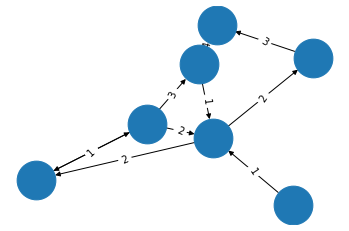

In [8]:
G = nx.DiGraph()

G.add_edges_from([('A', 'B'),('B', 'A'), ('C','D'),('G','D')], weight=1)
G.add_edges_from([('D','A'),('D','E'),('B','D'),('D','E')], weight=2)
G.add_edges_from([('B','C'),('E','F')], weight=3)
G.add_edges_from([('C','F')], weight=4)


edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])

pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_size=1500,edge_cmap=plt.cm.Reds)

With an initial value of n and starting node A, while assuming all of the nodes have an in-edge and out-edge, I want to traverse every path in the network and constantly divide the starting n by the value of the directional edge, and then find the path that maximizes n such that I end up at node A again.

For example, if n = 100, this is an example path for a different graph, where I traverse some paths and get back a final value:

n / 2 = 50, 50 / 5 = 10, 10 / 2 = 5, 5 / 0.01 = 500

Is this possible in networkx?


# Initial Answer - Based on nx.simple_cycles

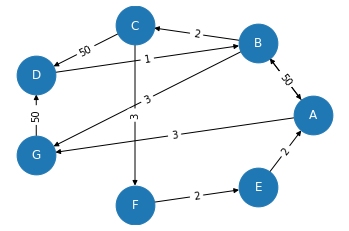

In [76]:
G = nx.DiGraph()

# replace original graph with one that has more cycles

G.add_edges_from([('A', 'B'),('B', 'A'), ('C','D'),('G','D')], weight=50)
G.add_edges_from([('D','B')], weight=1)
G.add_edges_from([('B','C'),('F','E'),('E','A')], weight=2)
G.add_edges_from([('C','F'),('B','G'),('A','G')], weight=3)

edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])

# improve layout and draw node labels

pos=nx.drawing.layout.circular_layout(G,scale=10)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw_networkx_labels(G,pos,font_color='white')
nx.draw(G,pos, node_size=1500,edge_cmap=plt.cm.Reds)


In [77]:
# node of interest
inode  = 'A'

# get all simple cycles in G that contain node of interest
acycs  = [ cyc for cyc in nx.simple_cycles(G) if inode in cyc ]

# for ease of computation we append the first node to the end of each cycle
acycs = [cyc+[cyc[0]] for cyc in acycs]

mcyc = []
maxn = 0

# for each cycle involving node of interest
for cyc in acycs:
    n = 100
    
    # group the nodes in the cycle by pairs
    for u, v in zip(cyc[:-1], cyc[1:]):
        
        # retrieve the respective edge weigth for the current pair
        print(u,v, end=',\t')
        div = G.get_edge_data(u,v)['weight']
        
        # calculate and update n
        r   = n/div
        print(f"{n}\t/\t{div}\t=\t{r}")
        n=r
        
    print('----------------------------------------------------------------------------')
    if n>maxn:
        maxn=n
        mcyc=cyc

E A,	100	/	2	=	50.0
A G,	50.0	/	3	=	16.666666666666668
G D,	16.666666666666668	/	50	=	0.33333333333333337
D B,	0.33333333333333337	/	1	=	0.33333333333333337
B C,	0.33333333333333337	/	2	=	0.16666666666666669
C F,	0.16666666666666669	/	3	=	0.05555555555555556
F E,	0.05555555555555556	/	2	=	0.02777777777777778
----------------------------------------------------------------------------
E A,	100	/	2	=	50.0
A B,	50.0	/	50	=	1.0
B C,	1.0	/	2	=	0.5
C F,	0.5	/	3	=	0.16666666666666666
F E,	0.16666666666666666	/	2	=	0.08333333333333333
----------------------------------------------------------------------------
B A,	100	/	50	=	2.0
A G,	2.0	/	3	=	0.6666666666666666
G D,	0.6666666666666666	/	50	=	0.013333333333333332
D B,	0.013333333333333332	/	1	=	0.013333333333333332
----------------------------------------------------------------------------
B A,	100	/	50	=	2.0
A B,	2.0	/	50	=	0.04
----------------------------------------------------------------------------


In [78]:
print(f"The loop {mcyc} in G maximizes n with {maxn}")

The loop ['E', 'A', 'B', 'C', 'F', 'E'] in G maximizes n with 0.08333333333333333


# Initial Answer - Based on nx.dijkstra_path

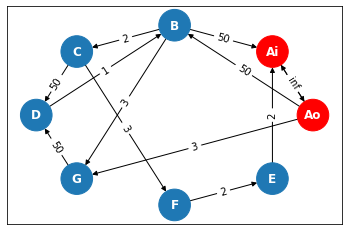

In [169]:
import math
Gp = nx.DiGraph()

Gp.add_edges_from([('Ao', 'B'),('B', 'Ai'), ('C','D'),('G','D')], weight=50)
Gp.add_edges_from([('D','B')], weight=1)
Gp.add_edges_from([('B','C'),('F','E'),('E','Ai')], weight=2)
Gp.add_edges_from([('C','F'),('B','G'),('Ao','G')], weight=3)

# this is actually not needed
Gp.add_edges_from([('Ai','Ao'),('Ao','Ai')], weight=math.inf)

edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in Gp.edges(data=True)])

pos=nx.drawing.layout.circular_layout(Gp,scale=10)
pos['Ai'], pos['B'] = pos['B'], pos['Ai']
nx.draw_networkx_edge_labels(Gp,pos,edge_labels=edge_labels)
nx.draw_networkx(Gp,pos,node_size=1000, font_weight='bold',font_color='white', node_color=['#1f78b4' if n not in ['Ai','Ao'] else '#ff0000' for n in Gp.nodes])

In [168]:
nmpath = nx.dijkstra_path(Gp,'Ao','Ai')
nmpath

['Ao', 'B', 'C', 'F', 'E', 'Ai']

In [114]:
lennmpath=len(nmpath)
datnmpath=[Gp.get_edge_data(u, nmpath[i+1])['weight'] for u,i in zip(nmpath[:-1], range(lnmpath))]

[50, 2, 3, 2, 2]

In [134]:
maxn=100; 
for w in datnmpath: maxn/=w
print(maxn)

0.08333333333333333



# By Jayson Salazar

|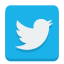|[@jdsalaro](https://twitter.com/jdsalaro)|
|-|:-|
|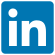|[https://linkedin.com/in/jdsalaro](http://linkedin.com/in/jdsalaro)|
|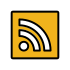|[https://jdsalaro.com](https://jdsalaro.com)|